In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/plays2024.csv')
threshold = 30
off_counts = df['offense_idx'].value_counts()
def_counts = df['defense_idx'].value_counts()
valid_off_teams = off_counts[off_counts >= threshold].index
valid_def_teams = def_counts[def_counts >= threshold].index

df_filtered = df[df['offense_idx'].isin(valid_off_teams) & df['defense_idx'].isin(valid_def_teams)].copy()
print("Total plays after filtering:", len(df_filtered))
print(df.info())

Total plays after filtering: 154412
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154412 entries, 0 to 154411
Data columns (total 44 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               154412 non-null  int64  
 1   offense                          154412 non-null  object 
 2   offense_conference               154412 non-null  object 
 3   defense                          154412 non-null  object 
 4   defense_conference               154412 non-null  object 
 5   home                             154412 non-null  object 
 6   away                             154412 non-null  object 
 7   offense_score                    154412 non-null  int64  
 8   defense_score                    154412 non-null  int64  
 9   game_id                          154412 non-null  int64  
 10  drive_id                         154412 non-null  int64  
 11  drive_number                 

In [14]:
df_4th = df_filtered[df_filtered['down'] == 4].copy()
print("Total 4th down plays:", len(df_4th))

df_4th['fourth_down_success'] = (df_4th['offense_score'] > 0)
print("Unique classes in fourth_down_success:", df_4th['fourth_down_success'].unique())
print("Value counts:\n", df_4th['fourth_down_success'].value_counts())

df_train = df_4th[df_4th['week'] < 9].copy() 
df_test  = df_4th[df_4th['week'] > 8].copy()  
print("Training 4th down plays:", len(df_train))
print("Testing 4th down plays:", len(df_test))

Total 4th down plays: 15890
Unique classes in fourth_down_success: [False  True]
Value counts:
 fourth_down_success
True     12482
False     3408
Name: count, dtype: int64
Training 4th down plays: 9507
Testing 4th down plays: 6383


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

X_train = df_train[['yards_to_goal', 'distance_to_goal']]
X_test  = df_test[['yards_to_goal', 'distance_to_goal']]
y_train = df_train['fourth_down_success']
y_test  = df_test['fourth_down_success']

print("Unique classes in y_train:", y_train.unique())
print("Value counts in y_train:\n", y_train.value_counts())
print("Unique classes in y_train:", y_train.unique())

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search_1 = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='liblinear'),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search_1.fit(X_train, y_train)

print("Best parameters for Model 1:", grid_search_1.best_params_)

Unique classes in y_train: [False  True]
Value counts in y_train:
 fourth_down_success
True     7336
False    2171
Name: count, dtype: int64
Unique classes in y_train: [False  True]
Best parameters for Model 1: {'C': 0.001}


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error


model = LogisticRegression(max_iter=1000, C=grid_search_1.best_params_['C'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_prob))
print("\nModel (4th down success without Team Coefficients):")
print("Test Accuracy:", round(acc, 3)*100, "%")
print("Test RMSE:", round(rmse, 3))


Model (4th down success without Team Coefficients):
Test Accuracy: 80.60000000000001 %
Test RMSE: 0.394


In [17]:
import pandas as pd

df_for_prediction = df_4th.dropna(subset=['yards_to_goal', 'distance_to_goal']).copy()
print("Number of drives used for prediction:", len(df_for_prediction))

df_for_prediction['predicted_prob'] = model.predict_proba(
    df_for_prediction[['yards_to_goal', 'distance_to_goal']]
)[:, 1]

team_predictions = df_for_prediction.groupby('offense').agg(
    total_attempts=('fourth_down_success', 'count'),
    actual_conversion_rate=('fourth_down_success', 'mean'),
    avg_predicted_prob=('predicted_prob', 'mean')
).reset_index()

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'] * 100
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'] * 100

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'].map("{:.2f}%".format)
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'].map("{:.2f}%".format)

team_predictions.to_csv("../results/4Th_Down_Without_Team_Coeff/2024.csv", index=False)
print("Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions_without_team_coefficients.csv'")
print(team_predictions.head())

Number of drives used for prediction: 15890
Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions_without_team_coefficients.csv'
             offense  total_attempts actual_conversion_rate avg_predicted_prob
0  Abilene Christian               8                 87.50%             80.85%
1          Air Force             109                 74.31%             76.85%
2              Akron             119                 85.71%             75.96%
3            Alabama              92                 90.22%             75.47%
4        Alabama A&M              16                 56.25%             76.23%


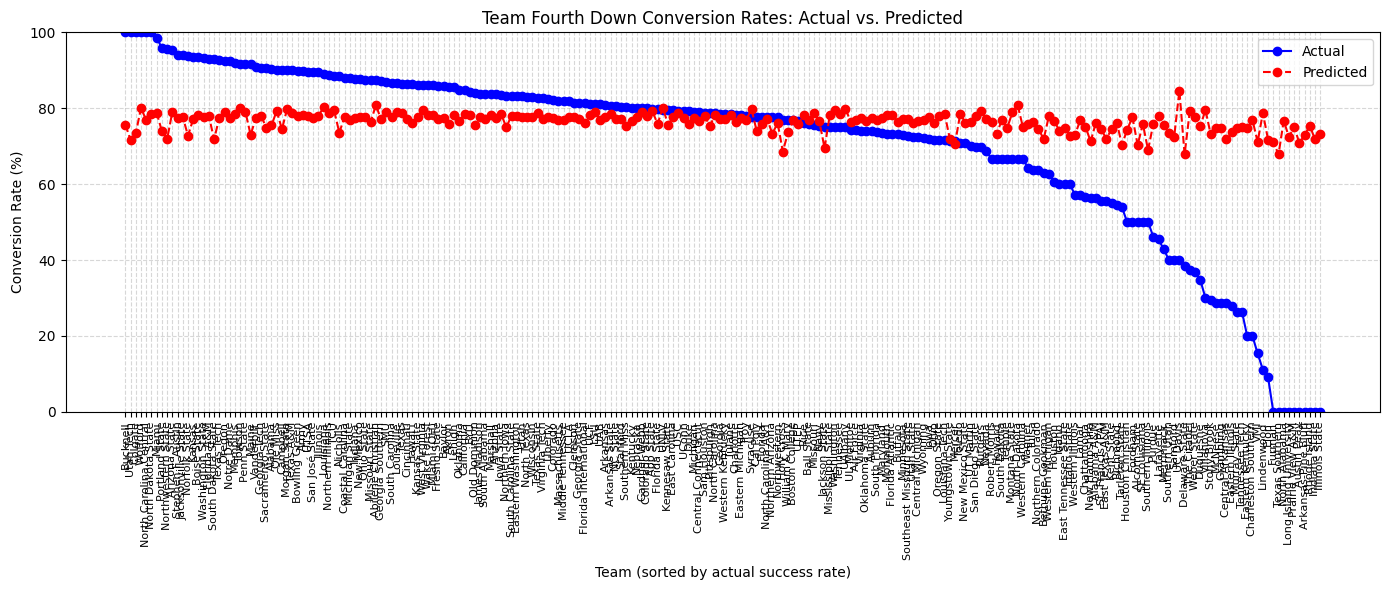

In [18]:
import matplotlib.pyplot as plt
import numpy as np

df_team = team_predictions.copy()

df_team['actual_conversion_rate_numeric'] = df_team['actual_conversion_rate'].str.rstrip('%').astype(float)
df_team['avg_predicted_prob_numeric'] = df_team['avg_predicted_prob'].str.rstrip('%').astype(float)

df_team = df_team.sort_values(by='actual_conversion_rate_numeric', ascending=False).reset_index(drop=True)

x = np.arange(len(df_team))

plt.figure(figsize=(14, 6))
plt.plot(x, df_team['actual_conversion_rate_numeric'], color='blue', linestyle='-', marker='o', label='Actual')
plt.plot(x, df_team['avg_predicted_prob_numeric'], color='red', linestyle='--', marker='o', label='Predicted')

plt.xlabel("Team (sorted by actual success rate)")
plt.ylabel("Conversion Rate (%)")
plt.title("Team Fourth Down Conversion Rates: Actual vs. Predicted")
plt.xticks(x, df_team['offense'], rotation=90, fontsize=8)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()